# Differential drive robot (a.k.a., the "segbot")

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy import linalg

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'C:\\Users\\Sebastian\\4. AE 353\\ae353-sp21-main\\projects\\02_segbot\\ae353_segbot.py'>

Create an instance of the robot simulator. This will open a window in which you should see the segbot.

There are three optional parameters:

* `damping` is the coefficient of viscous friction at each wheel joint (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.01`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [2]:
robot = ae353_segbot.RobotSimulator(damping=0., dt=0.01, display=True)

## Defining Physical Constraints

Variables and equations taken from DeriveEOM file

In [3]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Acceleration of gravity
g = 9.81

# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

## Defining Variables

with indication that they are real numbers)

In [4]:
(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_L,
 tau_R) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_L, tau_R', real=True)

## Computing the Equations of Motion

In [5]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

#full equation of motion result while implementing theta into the state
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [thetadot],
                [f]])

In [6]:
f

Matrix([
[                                                                                                                                                                              v*sin(e_h)],
[                                                                                                                                                                                       w],
[                                                                                                                                                                                thetadot],
[       -(2400*tau_L + 2400*tau_R + 2808*(thetadot**2 + w**2)*sin(theta) + 13*(250*tau_L + 250*tau_R - 195*w**2*sin(2*theta) - 8829*sin(theta))*cos(theta))/(11700*cos(theta)**2 - 12168)],
[                                                                       32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[(42250*tau_L + 42250*tau_R - 32955*w**2*sin(2*thet

## Defining Equilibrium Values and State-Space Model

Equilibrium values defined to be a part of the state, ```x``` and the input ```u```. Determine A and B matrices and correct to output a float matrix

In [7]:
#equilibrium values
e_le = 0
e_he = 0
ve = 5.6 
we = 0 
thetae = 0
thetadote = 0
tau_Le = 0
tau_Re = 0


#Create lambda functions A
A_num = sym.lambdify((e_l, e_h, theta, v, w, thetadot), f.jacobian([e_l, e_h, theta, v, w, thetadot]))

A = A_num(e_le, e_he, thetae, ve, we, thetadote).astype(float)

print('A =', A)

# Create lambda functions B
B_num = sym.lambdify((e_l, e_h, theta, v, w, thetadot), f.jacobian([tau_L, tau_R])) 

# Evaluate lambda function at equilibrium point
B = B_num(e_le, e_he, thetae, ve, we, thetadote).astype(float)

# Display the result
print('B=', B)

A = [[ 0.00000e+00  5.60000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   1.00000e+00]
 [ 0.00000e+00  0.00000e+00 -2.45250e+02  0.00000e+00  0.00000e+00
  -0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  1.06275e+03  0.00000e+00 -0.00000e+00
  -0.00000e+00]]
B= [[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 12.07264957  12.07264957]
 [ -1.05014439   1.05014439]
 [-51.46011396 -51.46011396]]


## Find the Controllability Matrix 

We want to prove that the state-space model is controllable, must check by ensuring that ```W``` and the rank of ```W``` are compatible

(looking for a rank of 6 for a 6 x 6 matrix)

In [8]:
W = B
n = A.shape[0]
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
    
print(W.tolist())
print(np.linalg.matrix_rank(W)) ##issues with determining rank, use w as a np.array()

[[0.0, 0.0, 0.0, 0.0, -5.880808611184037, 5.880808611184037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, -1.0501443948542923, 1.0501443948542923, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, -51.460113960113965, -51.460113960113965, 0.0, 0.0, -54689.23611111112, -54689.23611111112, 0.0, 0.0, -58120985.677083336, -58120985.677083336], [12.072649572649572, 12.072649572649572, 0.0, 0.0, 12620.59294871795, 12620.59294871795, 0.0, 0.0, 13412535.156250002, 13412535.156250002, 0.0, 0.0], [-1.0501443948542923, 1.0501443948542923, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-51.460113960113965, -51.460113960113965, 0.0, 0.0, -54689.23611111112, -54689.23611111112, 0.0, 0.0, -58120985.677083336, -58120985.677083336, 0.0, 0.0]]
6


## Linear Quadratic Regulator (LQR) 

Define the weight matrices ```Q``` and ```R```. The weights of the matrices will be adjusted through trial and error, goal is to minimize instability (the difference between lateral and heading error).

Solve for ```P``` which is the optimal cost matrix and use it to find ```K``` the gain matrix

In [9]:
# Define the weights
### Q matrix at starting 0 m/s
# Q = np.array([[1*300,0,0,0,0,0],
#              [0,1*260*0.5,0,0,0,0],
#              [0,0,1,0,0,0],
#              [0,0,0,1,0,0],
#              [0,0,0,0,1*260*0.5,0],
#              [0,0,0,0,0,1*300]])

### Q matrix at starting 5.6 m/s
Q = np.array([[1*360,0,0,0,0,0],
             [0,1*320*0.5,0,0,0,0],
             [0,0,1,0,0,0],
             [0,0,0,1,0,0],
             [0,0,0,0,1*320*0.5,0],
             [0,0,0,0,0,1*360]])

R = np.eye(2)

# Find the optimal cost matrix and gain matrix
P = linalg.solve_continuous_are(A, B, Q, R)

K = linalg.inv(R) @  B.T @ P
print(f'K = {K.tolist()}')

K = [[-13.416407864998936, -41.50654604846139, -23.944815633224675, -0.7071067811865324, -10.932731062028683, -13.600650619226993], [13.416407864998744, 41.50654604846103, -23.944815633224618, -0.7071067811865446, 10.932731062028708, -13.600650619226997]]


## Check for Stability

Test if the matrix ```K``` is stable by checking the eigenvalues of of ```F``` the result of ```A-BK```. The matrix ```K``` is stable when the eigenvalues have a negative real part.

In [10]:
F = A - B @ K
G = linalg.eigvals(F)
print(G.tolist())

[(-18.76421115095677+0j), (-2.0988406697604622+2.001105246823385j), (-2.0988406697604622-2.001105246823385j), (-1381.6944650582313+0j), (-0.7136601251785168+0j), (-0.30063165140347553+0j)]


## Defining Segbot Controller

Controller is defined using the state feedback equation ```u = -K*x``` where the state is defined as a difference between the measured variables and the equilibrium values. 

Make torque dependent on the state feedback by breaking up the 2 x 1 matrix into individual corresponding components.

In [11]:
class RobotController:
    def __init__(self, dt=0.01):
        self.dt = dt    
    
    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):

        #x = m - m_e
        m = np.array([[lateral_error], [heading_error], [pitch_angle], [forward_speed], [turning_rate], [pitch_rate]]) 
        m_e = np.array([[e_le],[e_he],[thetae],[ve],[we],[thetadote]])
        x = m - m_e
        u = -K @ x
        tau_left =   u[0,0] # <--- torque applied to left wheel (positive means rolling forward)
        tau_right =  u[1,0] # <--- torque applied to right wheel (positive means rolling forward)
        return tau_left, tau_right

controller = RobotController(dt=robot.dt)

## Running the Simulation

The simulation is a loop where each iteration determines
* sensor measurements
While allowing modifications to the 
* actuator commands

##### Modifying Code to Change Initial Speed

When changing the ```initial_speed``` from 0 m/s 
* Change the value to 5.6 m/s (the non-zero tested ```initial_speed```)
* Change the ```run_time```from 17 seconds to 13 seconds (to accurately model the time it takes to lap once)

In [12]:
# Restore the simulation to its initial state
robot.reset(turn_left=False,                            # does the robot turn left or right around the track
            ground_pitch=-0.,                           # angle that the track is sloped (rad)
            initial_speed= 5.6, #0.               # initial forward speed of segbot (m/s)
            initial_lateral_error= -0.00000000000001,   # initial lateral error of segbot (m)
            initial_heading_error=0.,                   # initial heading error of segbot (rad)
            initial_pitch=0.)                           # initial pitch angle of chassis (rad)

# Choose a camera view
#robot.camera_sideview()
#robot.camera_topview()
robot.camera_chaseview(yaw=270.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 17. #13.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'lateral_error': np.empty(num_steps, dtype=float),
    'heading_error': np.empty(num_steps, dtype=float),
    'forward_speed': np.empty(num_steps, dtype=float),
    'turning_rate': np.empty(num_steps, dtype=float),
    'pitch_angle': np.empty(num_steps, dtype=float),
    'pitch_rate': np.empty(num_steps, dtype=float),
    'tau_left_command': np.empty(num_steps, dtype=float),
    'tau_right_command': np.empty(num_steps, dtype=float),
    'tau_left': np.empty(num_steps, dtype=float),
    'tau_right': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    (lateral_error,
     heading_error,
     forward_speed,
     turning_rate,
     pitch_angle,
     pitch_rate) = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_left_command, tau_right_command = controller.run(lateral_error,
                                                         heading_error,
                                                         forward_speed,
                                                         turning_rate,
                                                         pitch_angle,
                                                         pitch_rate)
    
    # Apply the actuator commands
    tau_left, tau_right = robot.set_actuator_commands(tau_left_command, tau_right_command)
    
    # Log the data from this time step
    data['t'][step] = t
    data['lateral_error'][step] = lateral_error
    data['heading_error'][step] = heading_error
    data['forward_speed'][step] = forward_speed
    data['turning_rate'][step] = turning_rate
    data['pitch_angle'][step] = pitch_angle
    data['pitch_rate'][step] = pitch_rate
    data['tau_left_command'][step] = tau_left_command
    data['tau_right_command'][step] = tau_right_command
    data['tau_left'][step] = tau_left
    data['tau_right'][step] = tau_right
    
    # Simulate one time step
    robot.step(t=(start_time + (robot.dt * (step + 1))))

## Plot Results

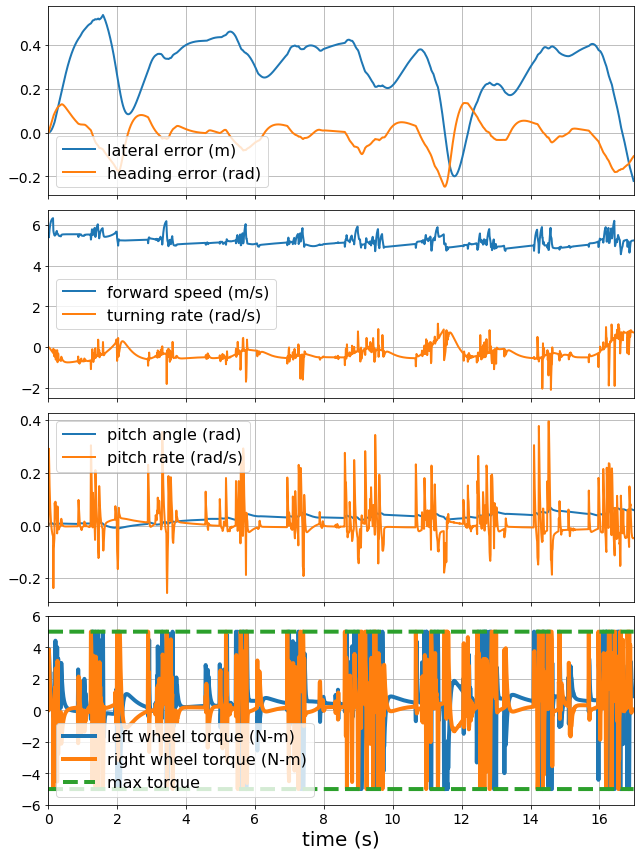

In [13]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# First subplot
ax[0].plot(data['t'], data['lateral_error'], label='lateral error (m)', linewidth=2)
ax[0].plot(data['t'], data['heading_error'], label='heading error (rad)', linewidth=2)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Second subplot
ax[1].plot(data['t'], data['forward_speed'], label='forward speed (m/s)', linewidth=2)
ax[1].plot(data['t'], data['turning_rate'], label='turning rate (rad/s)', linewidth=2)
ax[1].plot
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Third subplot
ax[2].plot(data['t'], data['pitch_angle'], label='pitch angle (rad)', linewidth=2)
ax[2].plot(data['t'], data['pitch_rate'], label='pitch rate (rad/s)', linewidth=2)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Fourth subplot
ax[3].plot(data['t'], data['tau_left'], label='left wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], data['tau_right'], label='right wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)
ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()